In [1]:
import pandas as pd
import torch
import numpy as np
from tqdm import tqdm
from torch_geometric.nn import SAGEConv
import torch
import torch_geometric
import torch.nn.functional as F
torch_geometric.set_debug(True)

ModuleNotFoundError: No module named 'torch_geometric'

# Helper Function to Construct the Graph

In [137]:
def mapping(data: pd.DataFrame):
    node_id_mapping, inverse_node_id_mapping = dict(), dict()
    for i, node_id in enumerate(data['image_name']):
        node_id_mapping[i] = node_id
        inverse_node_id_mapping[node_id] = i
    return node_id_mapping, inverse_node_id_mapping

In [138]:
def construct_nodes(data: pd.DataFrame):
    raw_features = data['embedding'].apply(lambda x: (' '.join(x.strip('[').strip(']').strip().split())).split(' '))
    return torch.from_numpy(np.array([[float(val) for val in feature_vector] for feature_vector in raw_features])).to(torch.float32)

In [139]:
def construct_edges(features: torch.tensor, threshold: float, method):
    source, target = [], []
    for i in tqdm(range(features.shape[0])):
        for j in range(i + 1, features.shape[0]):
            if method(features[i], features[j]) > threshold:
                source.append(i)
                target.append(j)
                source.append(j)
                target.append(i)
    return torch.tensor([source, target])

In [140]:
def get_labels(data: pd.DataFrame, subject_mapping):
    labels = data['class_name'].apply(lambda x: subject_mapping[x])
    return torch.tensor(labels)

In [141]:
def cosine_similarity(x: torch.tensor, y: torch.tensor):
    cos = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
    return cos(x,y)

def city_block(x: torch.tensor, y: torch.tensor):
    return torch.cdist(x, y, p=1)

def euclidian(x: torch.tensor, y: torch.tensor):
    return torch.cdist(x, y, p=2)

# Reading the Data and Exploring

In [142]:
data = pd.read_csv('imagenet_embeddings.csv')

In [143]:
classes = data['class_name'].unique()
subject_mapping = dict()
for i, class_name in enumerate(classes):
    subject_mapping[class_name] = i
subject_mapping

{'lion': 0, 'bear': 1, 'tarantula': 2, 'golden retriever': 3}

In [144]:
x = construct_nodes(data)
y = get_labels(data, subject_mapping)

In [145]:
def construct_matrix(matrix, method):
    n = matrix.shape[0]
    similarity_matrix = np.zeros((n, n))
    for i in tqdm(range(n)):
        for j in range(n):
            similarity_matrix[i][j] = method(matrix[i], matrix[j])
    return similarity_matrix

In [146]:
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(x)

In [196]:
def one_vs_rest(one_class: int, rest: np.array):
    same_class = []
    classes = [[], [], []]
    for i in range(500):
        same_class.append((sum(one_class[i]) - 1) / (len(one_class[i] - 1)))
        for j in range(3):
            rest_class = rest[i][j*500:(j+1)*500]
            classes[j].append(sum(rest_class) / len(rest_class))
    classes.append(same_class)
    return classes

In [197]:
test = []
for i in tqdm(range(4)):
    relevant_indeces = list(range(i * 500, (i+1) * 500))
    not_relevant = [k for k in range(2000) if k not in relevant_indeces] 
    one_class, rest = [], []
    for i in range(2000):
        if i in relevant_indeces:
            one_class.append(similarities[i])
        else:
            rest.append(similarities[i])
    test.append(one_vs_rest(one_class, rest))


100%|██████████| 4/4 [00:00<00:00,  5.36it/s]


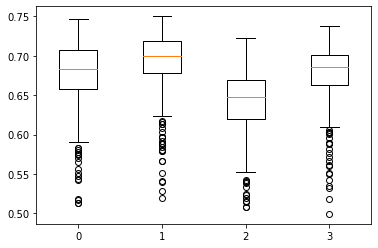

In [224]:
import matplotlib.pyplot as plt

plt.boxplot(test[0], positions=range(len(test[0])))
plt.show()

In [229]:
np.percentile(test[0][3], [10, 50, 90])

array([0.6370649 , 0.68520711, 0.71331078])

In [230]:
source, target = [], []
for i in tqdm(range(similarities.shape[0])):
    for j in range(similarities.shape[1]):
        if 0.637 < similarities[i][j] < 0.713 and i != j:
            source.append(i)
            target.append(j)
edges = torch.tensor([source, target])

100%|██████████| 2000/2000 [00:09<00:00, 206.71it/s]


In [231]:
train_indeces = list(range(0,400)) + list(range(500,900)) + list(range(1000,1400)) + list(range(1500,1900))
valid_indeces = list(range(400,450)) + list(range(900,950)) + list(range(1400,1450)) + list(range(1900,1950))
test_indeces = list(range(450,500)) + list(range(950,1000)) + list(range(1450,1500)) + list(range(1950,2000))

In [232]:
train_mask = torch.tensor([1 if i in train_indeces else 0 for i in range(x.shape[0])], dtype=torch.bool)
valid_mask = torch.tensor([1 if i in valid_indeces else 0 for i in range(x.shape[0])], dtype=torch.bool)
test_mask = torch.tensor([1 if i in test_indeces else 0 for i in range(x.shape[0])], dtype=torch.bool)

In [233]:
from torch_geometric.data import Data

data = Data(x=x, y=y, edge_index=edges, train_mask=train_mask, valid_mask=valid_mask, test_mask=test_mask)

In [234]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels, output_dim, seed=1):
        super().__init__()
        torch.cuda.manual_seed(seed)
        self.conv1 = SAGEConv((-1, -1), hidden_channels, normalize=True)
        self.conv2 = SAGEConv((-1, -1), hidden_channels//2, normalize=True)
        self.conv3 = SAGEConv((-1, -1), output_dim, normalize=True)

    def forward(self, x, edge_index):
        # TODO: Complete this function
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

In [239]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels, output_dim, seed=1):
        super().__init__()
        torch.cuda.manual_seed(seed)
        self.conv1 = SAGEConv((-1, -1), hidden_channels//2, aggr="mean", normalize=True)
        self.conv2 = SAGEConv((-1, -1), output_dim, aggr="mean", normalize=True)

    def forward(self, x, edge_index):
        # TODO: Complete this function
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [240]:
output_dim = len(subject_mapping)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(x.shape[1], output_dim).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [241]:
def train():
    # TODO: Complete this function
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model(data.x, data.edge_index)[train_mask], data.y[train_mask]).backward()
    optimizer.step()

In [242]:
def test():
    model.eval()
    logits = model(data.x, data.edge_index)
    accs = []
    for mask in [train_mask, valid_mask, test_mask]:
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

In [243]:
best_val_acc = test_acc = 0
for epoch in tqdm(range(1,20)):
    train()
    _, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    log = 'Epoch: {:03d}, Val: {:.4f}, Test: {:.4f}'
    
    if epoch % 1 == 0:
        print(log.format(epoch, best_val_acc, test_acc))

  5%|▌         | 1/19 [00:08<02:26,  8.15s/it]

Epoch: 001, Val: 0.2500, Test: 0.2500


 11%|█         | 2/19 [00:16<02:16,  8.02s/it]

Epoch: 002, Val: 0.3500, Test: 0.3450


 16%|█▌        | 3/19 [00:25<02:15,  8.48s/it]

Epoch: 003, Val: 0.4500, Test: 0.4350


 21%|██        | 4/19 [00:33<02:04,  8.32s/it]

Epoch: 004, Val: 0.6300, Test: 0.5950


 26%|██▋       | 5/19 [00:41<01:54,  8.20s/it]

Epoch: 005, Val: 0.6300, Test: 0.5950


 32%|███▏      | 6/19 [00:49<01:46,  8.21s/it]

Epoch: 006, Val: 0.6300, Test: 0.5950


 37%|███▋      | 7/19 [00:57<01:37,  8.15s/it]

Epoch: 007, Val: 0.6300, Test: 0.5950


 42%|████▏     | 8/19 [01:06<01:32,  8.39s/it]

Epoch: 008, Val: 0.6300, Test: 0.5950


 47%|████▋     | 9/19 [01:14<01:23,  8.37s/it]

Epoch: 009, Val: 0.6300, Test: 0.5950


 53%|█████▎    | 10/19 [01:23<01:15,  8.41s/it]

Epoch: 010, Val: 0.6300, Test: 0.5950


 58%|█████▊    | 11/19 [01:31<01:06,  8.35s/it]

Epoch: 011, Val: 0.6300, Test: 0.5950


 63%|██████▎   | 12/19 [01:40<00:59,  8.53s/it]

Epoch: 012, Val: 0.6300, Test: 0.5950


 68%|██████▊   | 13/19 [01:48<00:51,  8.53s/it]

Epoch: 013, Val: 0.6300, Test: 0.5950


 74%|███████▎  | 14/19 [01:57<00:42,  8.51s/it]

Epoch: 014, Val: 0.6300, Test: 0.5950
